[Methodology](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) adapted from terrific notebooks published by Sergio Rey and Arribas and their PySal [notebooks](http://pysal.org/notebooks/lib/libpysal/weights.html) page.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objs as go
import plotly.express as px
import os as os
import libpysal as lps
import spreg
from libpysal.weights import Queen, KNN
import esda
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_rel, shapiro
from sklearn import preprocessing
import json
np.random.seed(1728)

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Adjust directory accordingly
os.chdir('C:\\Users\\wesch\\OneDrive\\20 Spring Summer Urban Science Intensive\\nyconnect\\data')

In [3]:
# load datasets
subscription = pd.read_csv("./ACS_Internet_Subscription/subscription_acs_2018.csv")
income = pd.read_csv("./Demographics/Income/household_income_acs2018.csv")
race = pd.read_csv("./Demographics/Basic Count/tract_race_acs2018.csv")
census_tracts = gpd.read_file("./2010_Census_Tracts/geo_export_0ca1f0a1-f242-497a-9f86-91b88fc18647.shp")
mobile_rooftop = pd.read_csv("./Cellular_Towers/Mobile_Rooftop_Installations_CensusTract_2018.csv")
broadband_pricing = pd.read_csv("./Broadband Prices/broadband_price_census2018.csv")

In [4]:
# FCC data cleaning
fcc477_18 = pd.read_csv("./FCC_477/NY-Fixed-Jun2018-v1.csv", encoding = "ISO-8859-1")
fcc477_18.rename(columns={'Census Block FIPS Code':'FIPS'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_18["FIPS"] = fcc477_18["FIPS"].astype(str)
fcc477_18["FIPS_11"] = fcc477_18["FIPS"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_18_broadband = fcc477_18[(fcc477_18["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_18["Max Advertised Upstream Speed (mbps)"]>=3.0)]
# prepare for merging
fcc477_18_broadband_grouped = fcc477_18_broadband.groupby(["FIPS_11", "boro"]).agg(
    num_providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: len(x.unique())))
fcc477_18_broadband_grouped.reset_index(inplace=True)
fcc477_18_broadband_grouped["ct2010"] = fcc477_18_broadband_grouped["FIPS_11"].str[5:]
fcc477_18_broadband_grouped["boro"] = fcc477_18_broadband_grouped["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
# merge
fcc477_18_broadband_grouped_merged = fcc477_18_broadband_grouped.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
fcc477_18_broadband_grouped_merged["BoroCTLbl"] = fcc477_18_broadband_grouped_merged["boro_name"] + " " + fcc477_18_broadband_grouped_merged["ctlabel"].astype(str)
# select only for those columns
fcc477_18_broadband_grouped_merged = fcc477_18_broadband_grouped_merged[["BoroCTLbl", "num_providers"]]

In [5]:
# data cleaning 
## Calculating race as a percentage
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race[['city', 'tract', 'county', "BoroCTLbl", 'Total', 'White', 'Black', 'Native', 'Asian', 
                'PacificIslander', 'Other','TwoOrMore']]
## Calculating subscription as a percentage
subscription = subscription.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
## filling NAs
race = race.fillna(0)
income = income.fillna(0)
subscription = subscription.fillna(0)
## returning centroid of each census tract
census_tracts = census_tracts.assign(longitude = lambda x: x.geometry.centroid.x,
                                    latitude = lambda x: x.geometry.centroid.y)
## rename column of mobile rooftop
mobile_rooftop = mobile_rooftop.rename(columns={"NUMPOINTS":"num_rooftop_cells"})
## creating a new dataframe with all the variables 
all_vars = income.merge(race, on = ["city", "tract", "county", "BoroCTLbl"])
all_vars = all_vars.merge(subscription, on = ["city", "tract", "county", "BoroCTLbl"])
all_vars = all_vars.merge(census_tracts.loc[:, ["BoroCTLbl", "ntacode", "geometry"]], on = ["BoroCTLbl"])
all_vars = all_vars.merge(fcc477_18_broadband_grouped_merged, on = ["BoroCTLbl"])
all_vars = all_vars.merge(mobile_rooftop.loc[:,["num_rooftop_cells","BoroCTLbl"]], on = ["BoroCTLbl"])
all_vars = all_vars.merge(broadband_pricing.loc[:, ["BoroCTLbl", "price"]], on = ["BoroCTLbl"])
## rename variables 
renamed_cols = {
    'Total_x': 'PopulationCount',
    'Total_y' : 'HouseholdCount'}
all_vars.rename(columns=renamed_cols, inplace=True)
## dropping NAs
all_vars = all_vars.dropna()

In [44]:
# subscription rates versus number of providers
subscription_isps = all_vars
subscription_isps["mean_isps_borough"] = subscription_isps.groupby(["county"], group_keys = False).transform("mean")["num_providers"]
subscription_isps["mean_subscription_borough"] = subscription_isps.groupby(["county"], group_keys = False).transform("mean")["Wired_Broadband"]
# finding census tracts with above average infra provision but below average subscription
condition = [
    (subscription_isps["num_providers"]>subscription_isps["mean_isps_borough"]) & (subscription_isps["Wired_Broadband"]<subscription_isps["mean_subscription_borough"])]
choices = ["Under"]
subscription_isps["subscription_status"] = np.select(condition, choices, default = "Above")
# plotting
subscription_isps = gpd.GeoDataFrame(subscription_isps, crs = census_tracts.crs)
from matplotlib import colors
f, ax = plt.subplots(1, figsize=(9,9))
hmap = colors.ListedColormap(["#f0f0f0", "#636363"])
subscription_isps.plot(linewidth = 0.1, column = "subscription_status", categorical = True, cmap = hmap,
                                           ax = ax, edgecolor = "white", legend = True)
ax.set_axis_off()
ax.set_title("Under-subscribed Census Tracts")
plt.show()

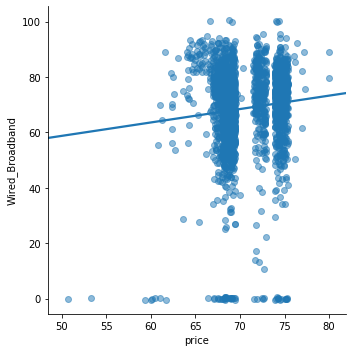

In [6]:
# pricing
pricing_subscription = subscription.merge(broadband_pricing.loc[:, ["BoroCTLbl", "price"]], on = ["BoroCTLbl"])

sns.lmplot(x = "price", y = "Wired_Broadband", data = pricing_subscription, ci = None,
           x_jitter = 0.75, y_jitter = 0.5, scatter_kws = {"alpha": 0.5})

In [ ]:
# exporting
all_vars.to_csv("./Demographics/Aggregated_Demographics.csv")

In [ ]:
# Creating spatial weights matrix
weights = Queen.from_dataframe(all_vars)
weights.transform = "r"

#### Local Spatial Autocorrelation and Local Moran's I Statistic

In [ ]:
def moran_scatter_map(all_vars_df, dep_var, weights, titles, census_tracts = census_tracts):
    # Creating y_var
    y = all_vars_df[dep_var]
    # Creating a lag variable 
    lag_var = lps.weights.lag_spatial(weights, y)
    # lm for moran and plotting
    b, a  = np.polyfit(y, lag_var, 1)
    f, ax = plt.subplots(1, figsize=(9,9))

    plt.plot(y, lag_var, ".", color = "#fb8072")

    plt.vlines(y.mean(), lag_var.min(),lag_var.max(), linestyle = "--")
    plt.hlines(lag_var.mean(), y.min(), y.max(), linestyle = "--")

    # plot line of best fit using global I as slope
    plt.plot(y, a+b*y, "#8da0cb")
    plt.title("Moran Scatterplot")
    plt.ylabel("Spatial Lag of " + titles)
    plt.xlabel(titles)
    plt.show()
    
  
    #calculating local moran's i 
    li = esda.moran.Moran_Local(y, weights)

    # classifying and quadrants (xy)
    sig = 1 * (li.p_sim < 0.05)
    highhigh = 1* (sig * li.q == 1)
    lowlow = 3* (sig * li.q == 3)
    lowhigh = 2* (sig * li.q == 2)
    highlow = 4* (sig * li.q == 4)

    spots = highhigh + lowlow + lowhigh + highlow
    spots_labels = ["0 Not Sig", "1 High-High", "2 Low-High", "3 Low-Low", "High-Low"]
    labels = [spots_labels[i] for i in spots]
    
    # plotting map
    from matplotlib import colors
    hmap = colors.ListedColormap(["#d9d9d9", "#fb8072", "#8dd3c7", "#80b1d3", "#bebada"])
    f, ax = plt.subplots(1, figsize=(9,9))
    relevant_tracts = all_vars_df.loc[:,["geometry"]]
    relevant_tracts = gpd.GeoDataFrame(relevant_tracts, crs = census_tracts.crs)
    relevant_tracts.assign(cl=labels).plot(column = "cl", categorical = True, k = 2, cmap = hmap, linewidth = 0.1, 
                                           ax = ax, edgecolor = "white", legend = True)
    ax.set_axis_off()
    ax.set_title("Spatial Association for " + titles)
    plt.show()

**Moran's I Scatterplot**:  
We are interested in Quadrants 1 and 3, the NE and SW respectively. If there is no spatial autocorrelation, we would not see such a strong positive correlation. The two quadrants represent clusters of contiguous Census Tracts with similar levels of home wired broadband subscription.  
  
The two dashed lines are the means of both axes. Values to below and above this are *low* and *high* respectively.   
  
**Spatial Association Map**:  
Here we can see a map of similarly valued clusters.

In [ ]:
moran_scatter_map(all_vars, "Wired_Broadband", weights, "Wired Broadband Subscription")

And prices? 

In [ ]:
moran_scatter_map(all_vars, "price", weights, "Wired Broadband Prices")

Well, isn't this interesting? It turns out that there is very strong spatial autocorrelation patterns. Census tracts in Manhattan tend to be surrounded by tracts with equally low prices whereas those in Queens, Staten Island,and northern Manhattan pay more for broadband, and so do their surrounding census tracts.

And what about the number of ISPs? Are they spatially autocorrelated too

In [ ]:
moran_scatter_map(all_vars, "num_providers", weights, "Number of ISPs")

Now we pivot towards mobile broadband dependence.

In [ ]:
moran_scatter_map(all_vars, "Mobile_Dependent", weights, "Mobile Broadband Dependence")

Repeating this analysis for mobile broadband dependence, we can see that a not entirely dissimilar pattern emerge. Clusters of census tracts with high mobile broadband dependence tend to be close to the areas wih low wired broadband subscription rates. But it is not a perfect match, suggesting that mobile broadband is not a perfect substitution.

In [ ]:
moran_scatter_map(all_vars, "No_Internet", weights, "Households w/o Internet Access")

This is a much more perfect match with *wired broadband subscription* than *mobile broadband dependence*. Clusters with high levels of households without internet access tend to be found around LES, Coney Island, South Williamsburg, Flatbush, Brownsville, East Harlem, and much of southern Bronx. Uncoincidentally, these tend to be areas with lower incomes and more racial minorities.

#### Spatial Regression for Wired Broadband

Why are these spatial regressions special? They take into account spatial fixed effects. They do not assume that the dependent variable behaves uniformly acrss spacewith systematic effects. In so doing, we introduce econometrically the notion of spatial heterogeneity by allowing the constant term (regime) to vary geographically.

In [ ]:
y = all_vars.loc[:,["Wired_Broadband"]]
indep_vars = all_vars[['num_providers', 'Households (HH) Count', 'HH 0-10k', 'HH 10k-15k', 'HH 15k-25k', 'HH 25k-35k', 
                       'HH 35k-50k', 'HH 50k-75k', 'HH 75k-100k', 'HH 100k-150k', 'HH 150k-200k', 'HH 200k-UP', 
                       "Household Median Income", "Household Mean Income",'PopulationCount', 'White', 'Black', 'Native',
                       'Asian', 'PacificIslander', 'Other', 'TwoOrMore', "price"]]

In [ ]:
regimes = list(all_vars["county"])

In [ ]:
m1 = spreg.OLS_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [ ]:
print(m1.summary)

From the above, we can conclude that race is not statistically significant in testing for wired broadband subscription. Income is a much better predictor. Interesting enough, the number of providers is **NOT** significant either.  
At the bottom of the summary object are four statistics for spatial dependence. I tested whether the residuals of the regression are spatially correlated, against the null of a random distribution over a designated space, NYC's census tracts in this case. Since, the tests reject the null hypothesis that error terms are randomly distributed in space, the normal OLS assumption of randomness is violated. Thus, OLS on its own is not particularly well suited. 

In [ ]:
m2 = spreg.GM_Lag_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [ ]:
print(m2.summary)

The results are roughly similar, and we can see that the spatially lagged variable is significant. What this means is that there is some form of spatial interaction between census tracts that causes some autocorrelation in wired broadband subscription. Even if we are not entirely convinced that a regression model can predict the rates of household broadband subscription, we want to see whether a lagged model can reduce MSE. Interestingly enough, even though the number of providers is not always significant, there is still some evidence of omitted variable bias. MSE was higher in the regressions without the number of providers. 

As a test, we can see what happens if we do not take into account fixed effects by measuring the differences in MSEs. Clearly, taking into account fixed effects at the borough level can reduce the mean squared errors very significantly.

In [ ]:
m1_2 = spreg.OLS(y = np.array(y), x = np.array(indep_vars),
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")
m2_2 = spreg.GM_Lag(y = np.array(y), x = np.array(indep_vars),
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [ ]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'F.E. OLS': mse(y, m1.predy.flatten()),
                'F.E. Lag': mse(y, m2.predy.flatten()),
                'OLS': mse(y, m1_2.predy.flatten()),
                'Lag': mse(y, m2_2.predy.flatten())})
mses.sort_values()

#### Spatial Regression for Mobile Broadband

In [ ]:
y = all_vars.loc[:,["Mobile_Dependent"]]
indep_vars = all_vars[['Households (HH) Count',
       'HH 0-10k', 'HH 10k-15k', 'HH 15k-25k', 'HH 25k-35k', 'HH 35k-50k',
       'HH 50k-75k', 'HH 75k-100k', 'HH 100k-150k', 'HH 150k-200k',
       'HH 200k-UP', "Household Median Income", "Household Mean Income", 'PopulationCount', 'White', 'Black', 'Native', 'Asian',
       'PacificIslander', 'Other', 'TwoOrMore', "num_rooftop_cells"]]
m3 = spreg.GM_Lag_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "MobileBroadbandDependence_Pct")
print(m3.summary)

In [ ]:
m3_2 = spreg.GM_Lag(y = np.array(y), x = np.array(indep_vars),
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "MobileBroadbandDependence_Pct")

In [ ]:
mses = pd.Series({'F.E. Lag': mse(y, m3.predy.flatten()),
                 'Lag': mse(y, m3_2.predy.flatten())})
mses.sort_values()

The same effect can be seen here. Taking into spatial fixed effects have a significant impact on reducing MSEs.

#### Demographics within Moran I Clusters

Let us first look at household broadband subscription rates.

In [ ]:
# Creating y_var
y = all_vars["Wired_Broadband"]
    
#calculating local moran's i 
li = esda.moran.Moran_Local(y, weights)

# classifying and quadrants (xy)
sig = 1 * (li.p_sim < 0.05)
highhigh = 1* (sig * li.q == 1)
lowlow = 3* (sig * li.q == 3)
lowhigh = 2* (sig * li.q == 2)
highlow = 4* (sig * li.q == 4)

spots = highhigh + lowlow + lowhigh + highlow
spots_labels = ["0 Not Sig", "1 High-High", "2 Low-High", "3 Low-Low", "High-Low"]
labels = [spots_labels[i] for i in spots]

# adding labels
demographics = all_vars.iloc[:,5:24]
demographics = demographics.assign(hh_broadband_m1=labels)

In [ ]:
highs = demographics.loc[(demographics.hh_broadband_m1=="1 High-High")]
highs = highs.loc[:, ["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
high_cosine_sim = cosine_similarity(highs, highs)
lows = demographics.loc[((demographics.hh_broadband_m1=="3 Low-Low"))]
lows = lows.loc[:, ["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
lows_cosine_sim = cosine_similarity(lows, lows)
demographics_num = demographics.loc[:,["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
demographics_cosine_sim = cosine_similarity(demographics_num, demographics_num)

In [ ]:
print("Average cosine similarity (%) between \n" + 
     "High-High Cluster: " + str(round(np.mean(high_cosine_sim)*100,2)) + 
     "\nLow-Low Cluster: "+ str(round(np.mean(lows_cosine_sim)*100,2)) + 
     "\nAll Census Tracts: "+ str(round(np.mean(demographics_cosine_sim)*100,2)))

Demographically, it appears that census tracts with high levels of household broadband subscription are more homogenous than those with low levels of household broadband subscription.  

### Comparing 2017 w/ 2018

In [ ]:
# load datasets
subscription_17 = pd.read_csv("./ACS_Internet_Subscription/subscription_acs_2017.csv")
subscription_18 = pd.read_csv("./ACS_Internet_Subscription/subscription_acs_2018.csv")
with open("./2010_Census_Tracts/census_tracts.geojson") as f:
    census_tracts_json = json.load(f)

# change column names
subscription_17.columns = ["city", "tract", "county", "BoroCTLbl", "total_17", "mobile_17", "wired_17", "no_int_17"]
subscription_18.columns = ["city", "tract", "county", "BoroCTLbl", "total_18", "mobile_18", "wired_18", "no_int_18"]

# merged dataset
subscription_merged = subscription_17.merge(subscription_18.loc[:,["BoroCTLbl", "total_18", "mobile_18", "wired_18", "no_int_18"]], left_on = "BoroCTLbl", right_on = "BoroCTLbl")

# calculating changes
subscription_merged = subscription_merged.assign(
    total_change = lambda x: (x["total_18"]-x["total_17"])/x["total_17"],
    mobile_change = lambda x: (x["mobile_18"]-x["mobile_17"])/x["mobile_17"],
    wired_hh_change = lambda x: (x["wired_18"]-x["wired_17"])/x["wired_17"],
    no_int_change = lambda x: (x["no_int_18"]-x["no_int_17"])/x["no_int_17"])

# replacing NaNs and undefined
subscription_merged = subscription_merged.fillna(0)
subscription_merged = subscription_merged.replace(np.inf, 1)

In [ ]:
# to make them look gaussian but disable forced scaling of mean to 0 and unit variance
mobile_17_scaled = preprocessing.scale(subscription_merged["mobile_17"], with_mean = False, with_std = False)
mobile_18_scaled = preprocessing.scale(subscription_merged["mobile_18"], with_mean = False, with_std = False)
wired_hh_17_scaled = preprocessing.scale(subscription_merged["wired_17"], with_mean = False, with_std = False)
wired_hh_18_scaled = preprocessing.scale(subscription_merged["wired_18"], with_mean = False, with_std = False)
no_int_17_scaled = preprocessing.scale(subscription_merged["no_int_17"], with_mean = False, with_std = False)
no_int_18_scaled = preprocessing.scale(subscription_merged["no_int_18"], with_mean = False, with_std = False)

#### Statistical Tests  
  
First, we have to run a few tests to see whether the differences over the years are statistically significant.

In [ ]:
stat, p = ttest_rel(mobile_17_scaled, mobile_18_scaled)
if p > 0.01:
    print("At C.I. of 99%, there are no differences between the two w.r.t subscription of mobile broadband.")
else:
    print("At C.I. of 99%, the two years are different w.r.t subscription of mobile broadband.")

In [ ]:
stat, p = ttest_rel(wired_hh_17_scaled, wired_hh_18_scaled)
if p > 0.01:
    print("At C.I. of 99%, there are no differences between the two w.r.t subscription of wired household broadband.")
else:
    print("At C.I. of 99%, the two years are different w.r.t subscription of wired household broadband.")

In [ ]:
stat, p = ttest_rel(no_int_17_scaled, no_int_18_scaled)
if p > 0.01:
    print("At C.I. of 99%, there are no differences between the two w.r.t the prop. of households w/o any internet subscription.")
else:
    print("At C.I. of 99%, the two years are different w.r.t the prop. of households w/o any internet subscription.")

Okay, so the differences are statistically significant, meaning that there probably are **real** changes between 2017 and 2018.

In [ ]:
# removing outliers
wired_hh_subscription_no_outliers = subscription_merged[(subscription_merged["wired_hh_change"]!=-1) & (subscription_merged["wired_hh_change"]<1)]
mobile_subscription_no_outliers = subscription_merged[(subscription_merged["mobile_change"]!=-1) & (subscription_merged["mobile_change"]<1)]
no_int_subscription_no_outliers = subscription_merged[(subscription_merged["no_int_change"]!=-1) & (subscription_merged["no_int_change"]<1)]
total_subscription_no_outliers = subscription_merged[(subscription_merged["total_change"]!=-1) & (subscription_merged["total_change"]<1)]

In [ ]:
fig = px.choropleth(wired_hh_subscription_no_outliers, geojson=census_tracts_json, color = "wired_hh_change", featureidkey = "properties.BoroCTLbl", 
                    locations = "BoroCTLbl", projection = "albers usa",
                   color_continuous_scale="Viridis")
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0},
                 title_text = "Percentage Difference in Household Wired Broadband Subscription")
fig.show()

In [ ]:
fig = px.choropleth(mobile_subscription_no_outliers, geojson=census_tracts_json, color = "mobile_change", featureidkey = "properties.BoroCTLbl", 
                    locations = "BoroCTLbl", projection = "albers usa",
                   color_continuous_scale="Viridis")
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0},
                 title_text = "Percentage Difference in Mobile Broadband Subscription")
fig.show()

In [ ]:
fig = px.choropleth(no_int_subscription_no_outliers, geojson=census_tracts_json, color = "no_int_change", featureidkey = "properties.BoroCTLbl", 
                    locations = "BoroCTLbl", projection = "albers usa",
                   color_continuous_scale="Inferno_r")
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0},
                 title_text = "Percentage Difference in Households Without Internet")
fig.show()

In [ ]:
fig = px.choropleth(total_subscription_no_outliers, geojson=census_tracts_json, color = "total_change", featureidkey = "properties.BoroCTLbl", 
                    locations = "BoroCTLbl", projection = "albers usa",
                   color_continuous_scale="Inferno")
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0},
                 title_text = "Percentage Difference in Total Number of Households")
fig.show()

### FCC Data from 2017/2018

In [ ]:
# FCC data cleaning
fcc477_17 = pd.read_csv("./FCC_477/NY-Fixed-Jun2017-v3.csv", encoding = "ISO-8859-1")
fcc477_17.rename(columns={'Census Block FIPS Code':'FIPS'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_17["FIPS"] = fcc477_17["FIPS"].astype(str)
fcc477_17["FIPS_11"] = fcc477_17["FIPS"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_17_broadband = fcc477_17[(fcc477_17["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_17["Max Advertised Upstream Speed (mbps)"]>=3.0)]
# prepare for merging
fcc477_17_broadband_grouped = fcc477_17_broadband.groupby(["FIPS_11", "boro"]).agg(
    num_providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: len(x.unique())))
fcc477_17_broadband_grouped.reset_index(inplace=True)
fcc477_17_broadband_grouped["ct2010"] = fcc477_17_broadband_grouped["FIPS_11"].str[5:]
fcc477_17_broadband_grouped["boro"] = fcc477_17_broadband_grouped["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
# merge
fcc477_17_broadband_grouped_merged = fcc477_17_broadband_grouped.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
fcc477_17_broadband_grouped_merged["BoroCTLbl"] = fcc477_17_broadband_grouped_merged["boro_name"] + " " + fcc477_17_broadband_grouped_merged["ctlabel"].astype(str)
# select only for those columns
fcc477_17_broadband_grouped_merged = fcc477_17_broadband_grouped_merged[["BoroCTLbl", "num_providers"]]

# comparing the two
fcc477_1718_difference = fcc477_17_broadband_grouped_merged.merge(fcc477_18_broadband_grouped_merged, left_on = "BoroCTLbl", right_on = "BoroCTLbl", suffixes = ("_17", "_18") )
fcc477_1718_difference = fcc477_1718_difference.assign(
    difference = lambda x: x["num_providers_18"] - x["num_providers_17"])

Evidently, pretty much all of the increase in ISPs are concentrated in Manhattan whereas there was consolidation of the market in northern and western Brooklyn.

In [ ]:
colorscale = ['#ca0020','#f4a582','#f7f7f7','#92c5de','#0571b0']
fig = px.choropleth(fcc477_1718_difference, geojson=census_tracts_json, color = "difference", featureidkey = "properties.BoroCTLbl", 
                    locations = "BoroCTLbl", projection = "albers usa",
                   color_continuous_scale = colorscale)
fig.update_geos(fitbounds = "locations", visible = False)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0},
                 title_text = "Difference in Number of ISPs")
fig.show()

In [ ]:
isp_subscriber = fcc477_1718_difference.merge(subscription_merged.loc[:, ["BoroCTLbl", "wired_hh_change"]], on = "BoroCTLbl")

In [ ]:
isp_subscriber["difference"] = isp_subscriber["difference"].astype(float)
isp_subscriber["wired_hh_change"] = isp_subscriber["wired_hh_change"].astype(float)
isp_subscriber["num_providers_18_str"] = isp_subscriber["num_providers_18"].astype(str)
isp_subscriber = isp_subscriber.merge(census_tracts.loc[:, ["BoroCTLbl", "boro_name"]], on = "BoroCTLbl")

Funnily enough, changing the number of ISPs does not appear to have any impact of household wired broadband subscription. The number of ISPs shown on

In [ ]:
sns.catplot(x="difference", y="wired_hh_change", hue="num_providers_18_str", col="boro_name",
            data=isp_subscriber, height=5, col_wrap = 3, alpha = 0.8, kind = "swarm")